<a href="https://colab.research.google.com/github/ML-ctrl/Thesis-ML_2022/blob/main/CALENDA_TEXT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
warnings.filterwarnings("ignore", category=DeprecationWarning)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re
import matplotlib.pyplot as plt

In [ ]:
import gdown

# Download the file using gdown
url = "https://drive.google.com/uc?id=1Oh2KZXteF4FyhDO7YXi3X0kOn-yOY_5z"
output = 'Calenda_posts.xlsx'
gdown.download(url, output, quiet=False)

# Read the downloaded Excel file into a Pandas DataFrame
df = pd.read_excel(output, header=0, names=['text', 'id', 'url'])

# Display the first few rows of the DataFrame to understand what it looks like
print(df.head())

Downloading...
From: https://drive.google.com/uc?id=1Oh2KZXteF4FyhDO7YXi3X0kOn-yOY_5z
To: /content/Calenda_posts.xlsx
100%|██████████| 34.5k/34.5k [00:00<00:00, 20.3MB/s]

                                                text                   id  \
0  Bonomi ha ragione. È incredibile il fatto che ...  3322110098234972018   
1  Parlare ad ogni elezione di “vento che cambia”...  3321294674173990657   
2  Il Patto repubblicano. \n\n1) Stati Uniti d’Eu...  3260379198833313961   
3  Abbiamo analizzato il “maestrale” della Sardeg...  3321984442625111754   
4  Duro monito di Giorgia Meloni al Governo di Gi...  3322159760480608203   

                                        url  
0  https://www.instagram.com/p/C4agYh2CJdy/  
1  https://www.instagram.com/p/C4Xm-jAiZcB/  
2  https://www.instagram.com/p/C0_MZtriEip/  
3  https://www.instagram.com/p/C4aDz_8CzbK/  
4  https://www.instagram.com/p/C4arrNaix_L/  


In [ ]:
corpus = df['text'].tolist()
print(corpus)

['Bonomi ha ragione. È incredibile il fatto che mentre in tutto il mondo si varano piani di stimolo per gli investimenti, qui, pur avendo i soldi non si riesce a farlo. Dall’esordio dell’Esecutivo abbiamo mandato norma e piani per varare industria 5.0. E siamo ancora a zero.', 'Parlare ad ogni elezione di “vento che cambia” è un clamoroso autogol. Le elezioni in Abruzzo confermano che l’elettorato di opinione non va a votare alle regionali. È un dato drammatico che menoma la democrazia.\n\nTrovate le mie considerazioni sul risultato abruzzese nella mia ultima newsletter: link nelle storie.', 'Il Patto repubblicano. \n\n1) Stati Uniti d’Europa a partire dal nucleo dei paesi fondatori. \n2) Atlantismo e rispetto degli accordi NATO sul 2% per le spese della difesa. Riaprire accordo libero scambio con USA.\n3) Spostamento della spesa corrente su istruzione e sanità \n4) Revisione del modello di contrattazione nazionale e salario minimo \n5) Uscita dello Stato e delle amministrazioni locali

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Since my data is in Italian, I will use the Italian stopwords provided by nltk, but I will also add my additional stopwords
stop_words = set(stopwords.words('italian'))
# Additional stop words
additional_stopwords = {"il", "f", "o", "si", "fino" "mettere", "portare", "così", "senza", "os", "da", "d", "fa", "oggi", "fatto", "essere", "solo", "cose"}

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

def nltk_clean_text(text):
    if isinstance(text, list):
        text = ' '.join(text)

    # Tokenize and lemmatize, remove stop words and non-alphabetic tokens
    tokens = word_tokenize(str(text).lower())  # Lowercasing text and converting to string
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]
    # Explicitly filtering additional stopwords
    filtered_tokens = [token for token in filtered_tokens if token not in additional_stopwords]
    return ' '.join(filtered_tokens)

df['nltk_cleaned_text'] = df['text'].apply(nltk_clean_text)

df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,id,url,nltk_cleaned_text
0,Bonomi ha ragione. È incredibile il fatto che ...,3322110098234972018,https://www.instagram.com/p/C4agYh2CJdy/,bonomi ragione incredibile mentre mondo varano...
1,Parlare ad ogni elezione di “vento che cambia”...,3321294674173990657,https://www.instagram.com/p/C4Xm-jAiZcB/,parlare ogni elezione vento cambium clamoroso ...
2,Il Patto repubblicano. \n\n1) Stati Uniti d’Eu...,3260379198833313961,https://www.instagram.com/p/C0_MZtriEip/,patto repubblicano stati uniti europa partire ...
3,Abbiamo analizzato il “maestrale” della Sardeg...,3321984442625111754,https://www.instagram.com/p/C4aDz_8CzbK/,analizzato maestrale sardegna analizza scirocc...
4,Duro monito di Giorgia Meloni al Governo di Gi...,3322159760480608203,https://www.instagram.com/p/C4arrNaix_L/,duro monito giorgia meloni governo giorgia mel...


In [ ]:
#Word frequency
word_freq = df['nltk_cleaned_text'].apply(lambda x: x.split()).explode().value_counts()

print(word_freq)

nltk_cleaned_text
politica      27
putin         26
libertà       18
italia        18
governo       17
              ..
triste         1
conoscerla     1
romana         1
luoghi         1
cucca          1
Name: count, Length: 2148, dtype: int64


<ipython-input-23-44d2e070182a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='freq', y='term', data=word_freq_df.head(top_n), palette='viridis')


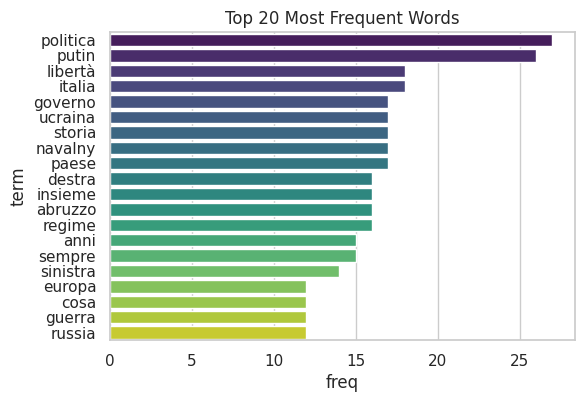

In [ ]:
# Converting the Series to a DataFrame
word_freq_df = word_freq.to_frame().reset_index()
word_freq_df.columns = ['term','freq']
word_freq_df.head()

import seaborn as sns
import matplotlib.pyplot as plt

top_n = 20
plt.figure(figsize=(6, 4))
sns.barplot(x='freq', y='term', data=word_freq_df.head(top_n), palette='viridis')

plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('freq')
plt.ylabel('term')

plt.show()

In [ ]:
data = df.text.values.tolist()

if False:
    df['nltk_clean_data'] = df['text'].str.replace("&#039;", "'", regex=False)
    # Remove Emails
    data = [re.sub(r'\S*@\S*\s?', '', str(sent)) for sent in data]
    # Remove new line characters
    data = [re.sub(r'\s+', ' ', str(sent)) for sent in data]
    # Remove distracting single quotes
    data = [re.sub(r"\'", "", str(sent)) for sent in data]

In [ ]:
import spacy
!python -m spacy download it_core_news_sm
nlp = spacy.load('it_core_news_sm')

def lemmatization(data):
    texts_out = []
    for text in data:
        # Check if the text is not NaN (float) and is a string
        if isinstance(text, str):
            doc = nlp(text)
            lemmatized_text = " ".join([token.lemma_ for token in doc])
            texts_out.append(lemmatized_text)
    return texts_out

lemmatized_texts = lemmatization(data)

def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 43.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


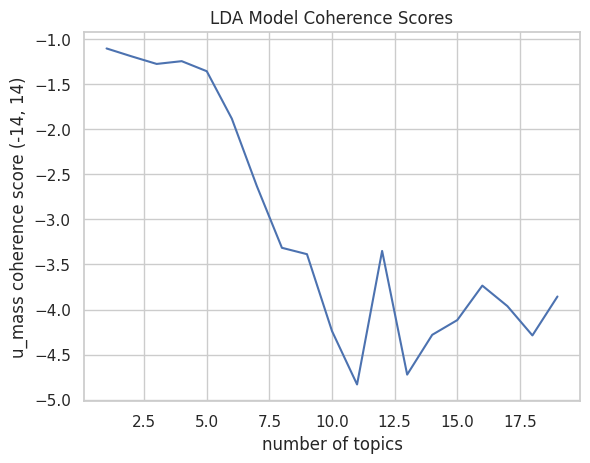

In [ ]:
topics = []
score = []

for i in range(1,20,1):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=i, iterations=10, passes=10, random_state=50)
  cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
  topics.append(i)
  score.append(cm.get_coherence())

plt.plot(topics, score)
plt.xlabel('number of topics')
plt.ylabel('u_mass coherence score (-14, 14)')
plt.title('LDA Model Coherence Scores')
plt.show()

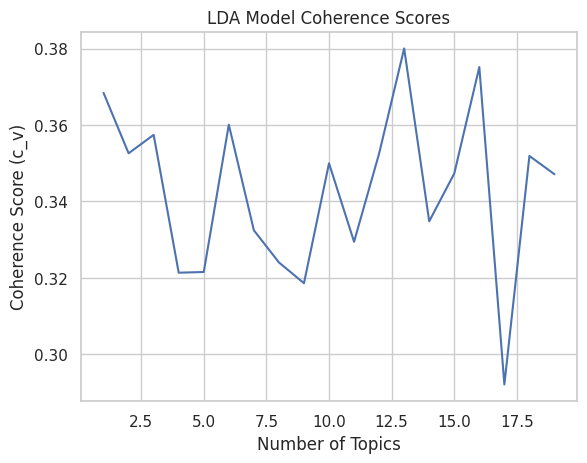

In [ ]:
topics = []
score = []

for i in range(1, 20, 1):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=i, iterations=10, passes=10, random_state=50)
    cm = CoherenceModel(model=lda_model, texts=data_words, corpus=corpus, dictionary=id2word, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())

plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (c_v)')
plt.title('LDA Model Coherence Scores')
plt.show()

In cv metric, the maximum value indicates the optimal topic coherence, while in the case of UMassmetric, the value close to zero indicates the highest coherence. When it comes to choosing the best coherence score, one solution is to implement the elbow technique. Usually, the coherence score will increase with the increase in the number of topics. This increase will become smaller as the number of topics gets higher. The trade-off between the number of topics and coherence score can be achieved using the elbow technique. Following Khalid and Wade (2020) "the elbow method helps the interpretation and validation of consistency within-cluster analysis and select the optimal number of clusters by fititng the model with a range of values of K". In other words, applied to my case it consists in the idea that one should choose a number of topic so that adding another topic doesn't give much better coherence score. Usign this technique I individuated the same number of topic with both u_mass and c_v topic coherences: 5.

In [ ]:
import gensim
from gensim import corpora

# Tokenize the text
tokenized_text = df['nltk_cleaned_text'].apply(lambda x: x.split())

# Create a dictionary from the tokenized text
dictionary = corpora.Dictionary(tokenized_text)

# Create a corpus (bag of words) from the tokenized text
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Define the number of topics base on LDA models
num_topics = 6

# Train the LDA model using the tokenized and bag-of-words formatted corpus
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=10, passes=10, random_state=100)

# Print topics
for topic in lda_model.print_topics():
    print(topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.009*"libertà" + 0.006*"navalny" + 0.006*"storia" + 0.005*"politica" + 0.005*"russia" + 0.005*"pericoloso" + 0.004*"viva" + 0.004*"anni" + 0.004*"italia" + 0.004*"sempre"')
(1, '0.007*"governo" + 0.006*"conte" + 0.005*"meloni" + 0.005*"quando" + 0.005*"politica" + 0.005*"abruzzo" + 0.004*"sinistra" + 0.004*"destra" + 0.003*"ore" + 0.003*"italia"')
(2, '0.012*"regime" + 0.007*"putin" + 0.007*"destra" + 0.005*"governo" + 0.005*"paese" + 0.004*"sinistra" + 0.003*"italia" + 0.003*"politica" + 0.003*"parole" + 0.003*"politico"')
(3, '0.007*"abruzzo" + 0.006*"insieme" + 0.006*"guerra" + 0.005*"putin" + 0.005*"anni" + 0.005*"ucraina" + 0.005*"destra" + 0.004*"sempre" + 0.004*"politica" + 0.004*"storie"')
(4, '0.009*"putin" + 0.007*"dopo" + 0.006*"libertà" + 0.006*"cosa" + 0.006*"bisogno" + 0.005*"storia" + 0.005*"ciò" + 0.005*"navalny" + 0.005*"ucraina" + 0.005*"tosta"')
(5, '0.009*"politica" + 0.005*"libertà" + 0.005*"stato" + 0.005*"cittadini" + 0.005*"paese" + 0.005*"piazza" + 0.004*

In [ ]:
# topic modeling plotting tools
!pip install -q pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Visualize the topics
#pyLDAvis.enable_notebook()
!pip install pandas==1.5.3 #To visualize the topics it is necessary to disinstall pandas 2.1.4 and instead install pandas 1.5.3

# Prepare the visualization
vis_data = pyLDAvis.gensim.prepare(lda_model,corpus, dictionary=lda_model.id2word)

# Display the visualization
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
!pip install -q transformers
!gdown https://drive.google.com/uc?id=10Z0dmx_3Ruq1FxVyMsB76NPHEApL-u3Z

fp = "sentiment.xlsx"
test_df = pd.read_excel(fp, header=None, names=['id','text', "sentiment"])
test_df.head()
print(test_df)
from transformers import pipeline

classifier = pipeline("text-classification",model='MilaNLProc/feel-it-italian-sentiment',top_k=2)
prediction = classifier("Oggi sono proprio contento!")
print(prediction)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Downloading...
From: https://drive.google.com/uc?id=10Z0dmx_3Ruq1FxVyMsB76NPHEApL-u3Z
To: /content/sentiment.xlsx
100% 55.7k/55.7k [00:00<00:00, 43.7MB/s]
    id                                               text  sentiment
0    0  Questo è stato un interessante e piena di sera...          1
1    1  Ottimo e ben organizzato. Nessuna coda all'ent...          1
2    3  Sconsiglio di visitarlo, è sopravvalutato e tr...          0
3    4  La vista del duomo all'uscita della metro non ...          0
4    5  Vivo a Milano da una vita ma non avevo mai tro...          1
5    6  Tenuto abbastanza bene, ma difficilmente acces...          0
6    8  Non ci sono parole per descrivere la bellezza ...          1
7    9  Un polmone verde in una grande città, uno dei ...          1
8   10  Visitare Milano nel periodo di Natale e' molto...          0
9   11  Bruttissimo in questa stagione , abbiamo girat...          0
10  12  E' una delle attrazioni più importanti da vede...          1
11  13  Quando si

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


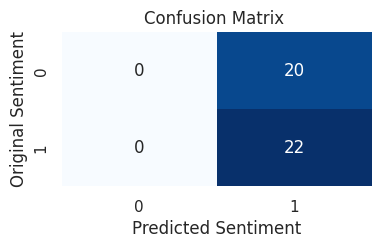

In [ ]:
from transformers import pipeline
from sklearn.metrics import confusion_matrix

# sentiment analysis model
model_name = "MilaNLProc/feel-it-italian-sentiment"

# sentiment analysis pipeline
nlp = pipeline("text-classification", model=model_name)

# predict sentiment on the original unaltered texts
test_df['HuggingFace Prediction'] = test_df['text'].apply(lambda text: nlp(text)[0])

# predicted sentiment labels from the pipeline results and convert to 0 (negative) or 1 (positive)
test_df['HuggingFace Confidence'] = test_df['HuggingFace Prediction'].apply(lambda prediction: prediction['score'])
test_df['HuggingFace Prediction'] = test_df['HuggingFace Prediction'].apply(lambda prediction: 0 if prediction['label'] == 'NEGATIVE' else 1)

# confusion matrix
conf_matrix = confusion_matrix(test_df['sentiment'], test_df['HuggingFace Prediction'])

# plot the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Sentiment")
plt.ylabel("Original Sentiment")
plt.title("Confusion Matrix ")
plt.show()

In [ ]:
from transformers import BertTokenizerFast, BertForSequenceClassification, pipeline

tokenizer = BertTokenizerFast.from_pretrained("osiria/bert-tweet-italian-uncased-sentiment")
model = BertForSequenceClassification.from_pretrained("osiria/bert-tweet-italian-uncased-sentiment")
classifier = pipeline("text-classification", model = model, tokenizer = tokenizer)

classifier("una fantastica giornata di #calcio! grande prestazione del mister e della squadra")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'label': 'POSITIVE', 'score': 0.9883694648742676}]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


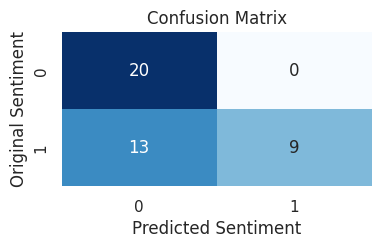

In [ ]:
from transformers import pipeline
from sklearn.metrics import confusion_matrix

# sentiment analysis model
model_name = "osiria/bert-tweet-italian-uncased-sentiment"

# sentiment analysis pipeline with model
nlp = pipeline("text-classification", model=model_name)

# predict sentiment on the original unaltered texts
test_df['HuggingFace Prediction'] = test_df['text'].apply(lambda text: nlp(text)[0])

# extract the predicted sentiment labels from the pipeline results and convert to 0 (negative) or 1 (positive)
test_df['HuggingFace Confidence'] = test_df['HuggingFace Prediction'].apply(lambda prediction: prediction['score'])
test_df['HuggingFace Prediction'] = test_df['HuggingFace Prediction'].apply(lambda prediction: 0 if prediction['label'] == 'NEGATIVE' else 1)

# confusion matrix
conf_matrix = confusion_matrix(test_df['sentiment'], test_df['HuggingFace Prediction'])

# plot the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Sentiment")
plt.ylabel("Original Sentiment")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Use the pipeline to predict sentiment on my own dataset
df['hf_nlp'] = df['nltk_cleaned_text'].apply(lambda text: nlp(text)[0])

df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,id,url,nltk_cleaned_text,hf_nlp
0,Bonomi ha ragione. È incredibile il fatto che ...,3322110098234972018,https://www.instagram.com/p/C4agYh2CJdy/,bonomi ragione incredibile mentre mondo varano...,"{'label': 'NEGATIVE', 'score': 0.9977622032165..."
1,Parlare ad ogni elezione di “vento che cambia”...,3321294674173990657,https://www.instagram.com/p/C4Xm-jAiZcB/,parlare ogni elezione vento cambium clamoroso ...,"{'label': 'NEGATIVE', 'score': 0.9961727261543..."
2,Il Patto repubblicano. \n\n1) Stati Uniti d’Eu...,3260379198833313961,https://www.instagram.com/p/C0_MZtriEip/,patto repubblicano stati uniti europa partire ...,"{'label': 'POSITIVE', 'score': 0.5529724359512..."
3,Abbiamo analizzato il “maestrale” della Sardeg...,3321984442625111754,https://www.instagram.com/p/C4aDz_8CzbK/,analizzato maestrale sardegna analizza scirocc...,"{'label': 'NEGATIVE', 'score': 0.640614926815033}"
4,Duro monito di Giorgia Meloni al Governo di Gi...,3322159760480608203,https://www.instagram.com/p/C4arrNaix_L/,duro monito giorgia meloni governo giorgia mel...,"{'label': 'NEGATIVE', 'score': 0.8012603521347..."


In [ ]:
# Extract the predicted sentiment labels from the pipeline results and convert to 0 (negative) or 1 (positive)
df['hf_prediction'] = df['hf_nlp'].apply(lambda prediction: 0 if prediction['label'] == 'NEGATIVE' else 1)
df['hf_confidence'] = df['hf_nlp'].apply(lambda prediction: prediction['score'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Get the mean of the prediction
df.hf_prediction.mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.18666666666666668

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-38-b447d46a26d6>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


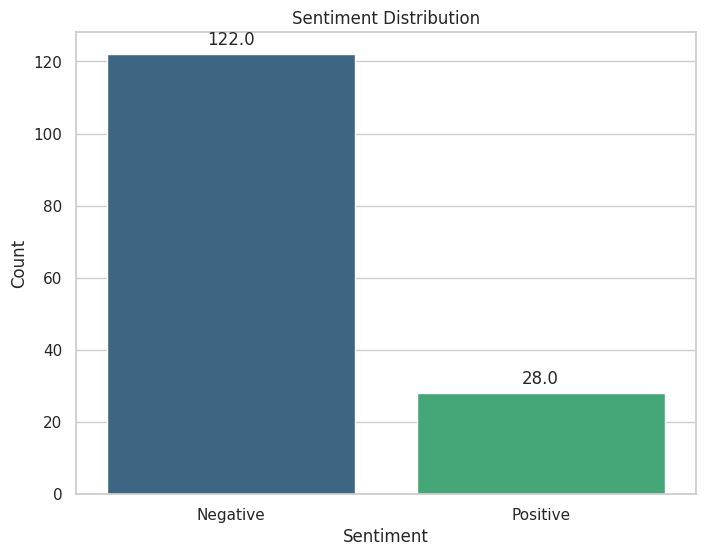

In [ ]:
#Visualization of te sentiment distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment
sentiment_counts = df['hf_prediction'].value_counts()

# Map numerical values to string labels
sentiment_mapping = {0: 'Negative', 1: 'Positive'}
sentiment_counts.index = sentiment_counts.index.map(sentiment_mapping)

# Plot the bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

# Set labels and title
ax.set(xlabel='Sentiment', ylabel='Count', title='Sentiment Distribution')

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [ ]:
from scipy.stats import chi2_contingency

# Observed frequencies
observed = [[122, 28], [94, 56]]

# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(observed)

# Print results
print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:")
print(expected)

# Compare with significance level (e.g., 0.05)
alpha = 0.05
if p < alpha:
    print("Reject null hypothesis: There is a significant difference between the distributions.")
else:
    print("Fail to reject null hypothesis: There is no significant difference between the distributions.")


Chi-squared statistic: 12.053571428571429
P-value: 0.0005169324744640473
Degrees of freedom: 1
Expected frequencies:
[[108.  42.]
 [108.  42.]]
Reject null hypothesis: There is a significant difference between the distributions.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import numpy as np
import statsmodels.api as sm

# Define the data
Y = np.array([94 / (94 + 56), 122 / (122 + 28)])  # Proportion of negative sentiment posts
X = np.array([1, 0])  # Predictor variable: 1 for Salvini, 0 for Calenda

# Fit logistic regression model
X = sm.add_constant(X)  # Add intercept term
model = sm.Logit(Y, X)
result = model.fit()

# Print the summary of the logistic regression model
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.482220
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                    2
Model:                          Logit   Df Residuals:                        0
Method:                           MLE   Df Model:                            1
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                     inf
Time:                        00:18:03   Log-Likelihood:               -0.96444
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4718      2.566      0.573      0.566      -3.558       6.502
x1            -0.9539      3.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Define the data
Y = np.array([94 / (94 + 56), 122 / (122 + 28)])  # Proportion of negative sentiment posts
X = np.array([1, 0])  # Predictor variable: 1 for Salvini, 0 for Calenda

# Fit logistic regression model
X = add_constant(X)
model = Logit(Y, X).fit()

# Print the summary of the logistic regression model
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.482220
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                    2
Model:                          Logit   Df Residuals:                        0
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Apr 2024   Pseudo R-squ.:                     inf
Time:                        16:06:10   Log-Likelihood:               -0.96444
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4718      2.566      0.573      0.566      -3.558       6.502
x1            -0.9539      3.

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:4

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Create a DataFrame with the data
data = {
    'Politician': [1]*130 + [2]*150,  # 1 for Salvini, 2 for Calenda
    'Sentiment': [1]*94 + [0]*36 + [1]*122 + [0]*28  # 1 for negative, 0 for positive
}

df = pd.DataFrame(data)

# Define the independent and dependent variables
X = df['Politician']
y = df['Sentiment']

# Add intercept term
X = sm.add_constant(X)

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print summary of the model
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.531807
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Sentiment   No. Observations:                  280
Model:                          Logit   Df Residuals:                      278
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Apr 2024   Pseudo R-squ.:                 0.01067
Time:                        16:25:02   Log-Likelihood:                -148.91
converged:                       True   LL-Null:                       -150.51
Covariance Type:            nonrobust   LLR p-value:                   0.07307
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4477      0.444      1.007      0.314      -0.423       1.319
Politician     0.5120      0.

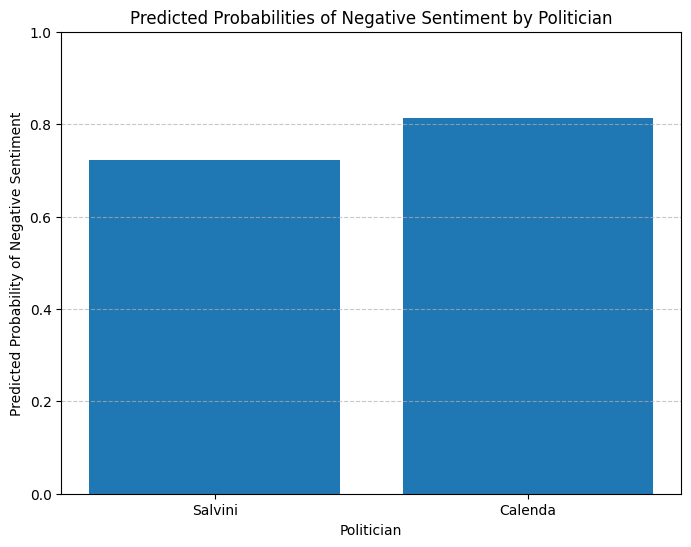

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients from the logistic regression results
beta0 = result.params['const']
beta1 = result.params['Politician']

# Define the logistic function
def logistic_func(x, beta0, beta1):
    return 1 / (1 + np.exp(-(beta0 + beta1 * x)))

# Values for the predictor variable (Politician)
politician_values = [1, 2]  # Salvini and Calenda

# Calculate predicted probabilities for each value of the predictor variable
predicted_probabilities = [logistic_func(x, beta0, beta1) for x in politician_values]

# Plot the predicted probabilities
plt.figure(figsize=(8, 6))
plt.bar(politician_values, predicted_probabilities)
plt.xlabel('Politician')
plt.ylabel('Predicted Probability of Negative Sentiment')
plt.title('Predicted Probabilities of Negative Sentiment by Politician')
plt.xticks(politician_values, ['Salvini', 'Calenda'])
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
